<h2> Try lxyuan/distilbert-base-multilingual-cased-sentiments-student on sentiment data and evaluate. Compare to your FFNN model. </h2>

In [1]:
from transformers import pipeline
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re

import numpy as np
from time import time
from tqdm.auto import tqdm

In [3]:
def processing(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    return text

data = []
label = []
with open('./sentiment.txt') as doc:
    for d in doc:
        line = d.strip().split('\t')
        # data.append(line[0].lower())
        data.append(processing(line[0].lower()))
        label.append(int(line[1]))

In [4]:
distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", 
    return_all_scores=True
)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
/home/uoa/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [5]:
pre_train = distilled_student_sentiment_classifier(data)

In [6]:
predict = [1 if prediction[0]['score'] > prediction[2]['score'] else 0 for prediction in pre_train]
accuracy = np.mean(np.array(predict) == np.array(label))

In [11]:
print(accuracy * 100, '%')

78.3 %


<center> 
    <h1> Fine tuning pretrained model </h1>
</center>

<center> 
    <h3> Import Library</h3>
</center>

In [62]:
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

from datasets import load_dataset
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer, DataCollatorWithPadding, create_optimizer, TFAutoModelForSequenceClassification


<center> 
    <h3> Read data and processing </h3>
</center>

In [6]:
data = []
with open('./sentiment.txt') as lines:
    for line in lines:
        data.append(line.strip().lower().split('\t'))

In [7]:
data

[['wow... loved this place.', '1'],
 ['crust is not good.', '0'],
 ['not tasty and the texture was just nasty.', '0'],
 ['stopped by during the late may bank holiday off rick steve recommendation and loved it.',
  '1'],
 ['the selection on the menu was great and so were the prices.', '1'],
 ['now i am getting angry and i want my damn pho.', '0'],
 ["honeslty it didn't taste that fresh.)", '0'],
 ['the potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
  '0'],
 ['the fries were great too.', '1'],
 ['a great touch.', '1'],
 ['service was very prompt.', '1'],
 ['would not go back.', '0'],
 ['the cashier had no care what so ever on what i had to say it still ended up being wayyy overpriced.',
  '0'],
 ['i tried the cape cod ravoli, chicken,with cranberry...mmmm!', '1'],
 ['i was disgusted because i was pretty sure that was human hair.', '0'],
 ['i was shocked because no signs indicate cash only.', '0'],
 ['highly recommended.', '1'

<center> 
    <h3> Split and convert to Dataset </h3>
</center>

In [11]:
data_train, data_test = train_test_split(data, test_size=0.4, random_state=0)
data_test, data_val = train_test_split(data_test, test_size=0.4, random_state=0)

In [12]:
len(data_train), len(data_test), len(data_val)

(600, 240, 160)

In [34]:
def getDataset(data):
    dataset = {'label':[], 'text':[]}
    for idx in range(len(data)):
        text = data[idx][0].strip()
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s{2,}', '', text)
        dataset['text'].append(text)
        dataset['label'].append(int(data[idx][1]))
    return dataset

In [35]:
dataset_train = getDataset(data_train)
dataset_test = getDataset(data_test)
dataset_val = getDataset(data_val)

In [37]:
dataset_dict = DatasetDict({
    'train': Dataset.from_dict(dataset_train),
    'test': Dataset.from_dict(dataset_test),
    'val': Dataset.from_dict(dataset_val)
})

In [38]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 600
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 240
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 160
    })
})

In [39]:
dataset_dict['test'][0]

{'label': 0,
 'text': 'the servers are not pleasant to deal with and they don t always honor pizza hut coupons '}

<center> 
    <h3> Preprocess </h3>
</center>

In [41]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [43]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [44]:
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [46]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

<center> 
    <h3> Fine-tune with TensorFlow </h3>
</center>

In [48]:
tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_dataset = tokenized_data["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["val"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [65]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [66]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [67]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [68]:
history = model.fit(x=tf_train_dataset, validation_data=tf_test_dataset, epochs=5)

Epoch 1/5
38/38 [==============================] - 26s 265ms/step - loss: 0.6503 - accuracy: 0.6417 - val_loss: 0.4948 - val_accuracy: 0.8750
Epoch 2/5
38/38 [==============================] - 8s 212ms/step - loss: 0.3298 - accuracy: 0.9083 - val_loss: 0.3264 - val_accuracy: 0.8625
Epoch 3/5
38/38 [==============================] - 7s 194ms/step - loss: 0.1396 - accuracy: 0.9633 - val_loss: 0.2323 - val_accuracy: 0.9125
Epoch 4/5
38/38 [==============================] - 7s 190ms/step - loss: 0.0902 - accuracy: 0.9800 - val_loss: 0.2346 - val_accuracy: 0.9167
Epoch 5/5
38/38 [==============================] - 7s 185ms/step - loss: 0.0686 - accuracy: 0.9867 - val_loss: 0.2340 - val_accuracy: 0.9167


<center> 
    <h3> History model </h3>
</center>

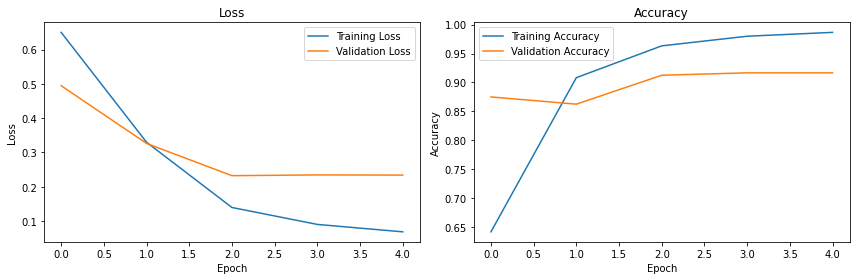

In [69]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<center> 
    <h3> evaluate model </h3>
</center>

In [70]:
validation_loss, validation_accuracy = model.evaluate(tf_validation_dataset)

print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")


10/10 [==============================] - 1s 55ms/step - loss: 0.3434 - accuracy: 0.8687
Validation Loss: 0.3434
Validation Accuracy: 86.87%
